In [36]:
%reload_ext autoreload
%autoreload 2
from utils import load_translate_from_csv
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text


In [37]:
examples= load_translate_from_csv('./data/fr_to_adj.csv')

train_examples, val_examples = examples['train'], examples['validation']

In [3]:
for fr_examples, aj_examples in train_examples.batch(3).take(1):
  print('> Examples in French:')
  for fr in fr_examples.numpy():
    print(fr.decode('utf-8'))
  print()

  print('> Examples in Adja:')
  for aj in aj_examples.numpy():
    print(aj.decode('utf-8'))


> Examples in French:
caisse
coffre
grenier

> Examples in Adja:
daka
daka 
ava 


2024-05-31 22:16:05.668962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
model_name = 'data/translate_fr_aj_converter'
tokenizers = tf.saved_model.load(model_name)

In [5]:
[item for item in dir(tokenizers.aj) if not item.startswith('_')]


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [6]:
MAX_TOKENS=128
def prepare_batch(fr, aj):
    fr = tokenizers.fr.tokenize(fr)      # Output is ragged.
    fr = fr[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    fr = fr.to_tensor()  # Convert to 0-padded dense Tensor

    aj = tokenizers.aj.tokenize(aj)
    aj = aj[:, :(MAX_TOKENS+1)]
    aj_inputs = aj[:, :-1].to_tensor()  # Drop the [END] tokens
    aj_labels = aj[:, 1:].to_tensor()   # Drop the [START] tokens

    return (fr, aj_inputs), aj_labels


In [7]:
BUFFER_SIZE = 2000
BATCH_SIZE = 16


In [8]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


In [9]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


In [10]:
for (fr, aj), aj_labels in train_batches.take(1):
  break

print(fr.shape)
print(aj.shape)
print(aj_labels.shape)


(16, 25)
(16, 21)
(16, 21)


2024-05-31 22:16:06.605030: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [11]:
from  transformer.positional_encoding import PositionalEmbedding
input_seq_length = 5  # Maximum length of the input sequence
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
h = 8  # Number of self-attention heads
d_ff = 2048

In [47]:
embed_fr = PositionalEmbedding(vocab_size=tokenizers.fr.get_vocab_size().numpy(), sequence_length= MAX_TOKENS, d_model=d_model)
embed_aj = PositionalEmbedding(vocab_size=tokenizers.aj.get_vocab_size().numpy(),sequence_length= MAX_TOKENS, d_model=d_model)

fr_emb = embed_fr(fr)
aj_emb = embed_aj(aj)


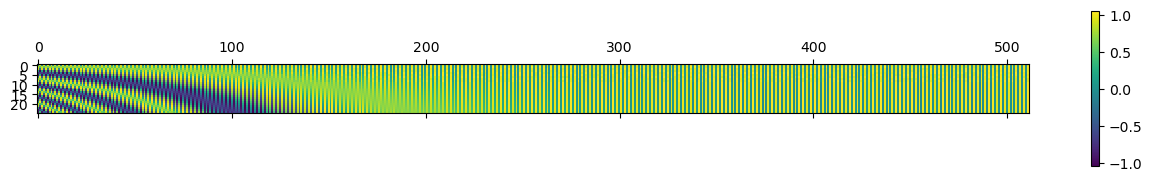

In [108]:
import matplotlib.pyplot as plt
cax = plt.matshow(fr_emb[0,:])
plt.gcf().colorbar(cax)

In [27]:
from transformer.base import CrossAttention


sample_ca = CrossAttention(h=h, d_k=d_k, d_v=d_v, d_model=d_model)

print(fr_emb.shape)
print(aj_emb.shape)
print(sample_ca(aj_emb, fr_emb).shape)


(16, 25, 512)
(16, 21, 512)
(16, 21, 512)


In [30]:
from transformer.base import GlobalSelfAttention


sample_gsa = GlobalSelfAttention(h=h, d_k=d_k, d_v=d_v, d_model=d_model)

print(fr_emb.shape)
print(sample_gsa(fr_emb).shape)

(16, 25, 512)
(16, 25, 512)


In [32]:
from transformer.base import CausalSelfAttention


sample_csa = CausalSelfAttention(h=h, d_k=d_k, d_v=d_v, d_model=d_model)

print(aj_emb.shape)
print(sample_csa(aj_emb).shape)


(16, 21, 512)
(16, 21, 512)


In [33]:
from transformer.base import FeedForward


sample_ffn = FeedForward(512, 2048)

print(aj_emb.shape)
print(sample_ffn(aj_emb).shape)


(16, 21, 512)
(16, 21, 512)


In [35]:
from transformer.encoder import EncoderLayer


sample_encoder_layer = EncoderLayer(h, d_k, d_v, d_model, d_ff)

print(fr_emb.shape)
print(sample_encoder_layer(fr_emb).shape)


(16, 25, 512)
(16, 25, 512)


In [39]:
# Instantiate the encoder.
from transformer.encoder import Encoder


sample_encoder = Encoder(4, tokenizers.fr.get_vocab_size().numpy(), MAX_TOKENS, h, d_k, d_v, d_model, d_ff)

sample_encoder_output = sample_encoder(fr, training=False)

# Print the shape.
print(fr.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.


(16, 25)
(16, 25, 512)


In [41]:
from transformer.decoder import DecoderLayer


sample_decoder_layer = DecoderLayer(h, d_k, d_v, d_model, d_ff)

sample_decoder_layer_output = sample_decoder_layer(x=aj_emb, values=fr_emb)

print(fr_emb.shape)
print(aj_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(16, 25, 512)
(16, 21, 512)
(16, 21, 512)


In [48]:
# Instantiate the decoder.
from transformer.decoder import Decoder


sample_decoder = Decoder(4, tokenizers.aj.get_vocab_size().numpy(), MAX_TOKENS, h, d_k, d_v, d_model, d_ff)

output = sample_decoder(x=aj,values=fr_emb)

# Print the shapes.
print(aj.shape)
print(fr_emb.shape)
print(output.shape)


(16, 21)
(16, 25, 512)
(16, 21, 512)


In [76]:
num_layers = 2
d_model = 128
d_ff = 512
num_heads = 8
dropout_rate = 0.1

In [77]:
from transformer.transformer import Transformer


transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    h=num_heads,
    d_k=d_k,
    d_v=d_v,
    d_ff=d_ff,
    input_vocab_size=tokenizers.fr.get_vocab_size().numpy(),
    output_vocab_size=tokenizers.aj.get_vocab_size().numpy(),
    sequence_length=MAX_TOKENS,
    dropout_rate=dropout_rate)


In [78]:
output = transformer((fr, aj))

print(aj.shape)
print(fr.shape)
print(output.shape)


(16, 21)
(16, 25)
(16, 21, 242)


In [79]:
transformer.summary()

Model: "transformer_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_9 (Encoder)             │ ?                      │       365,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_11 (Decoder)            │ ?                      │       428,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ ?                      │        31,218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,202 (3.15 MB)

 Trainable params: 825,202 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
from transformer.learning_rate import CustomSchedule


learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

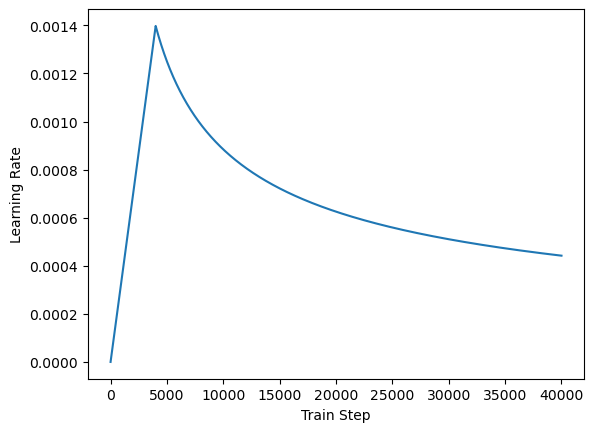

In [81]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')


In [82]:
from transformer.loss_metrics import masked_accuracy, masked_loss


transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])


In [93]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 4.6729 - masked_accuracy: 0.2111 - val_loss: 4.1410 - val_masked_accuracy: 0.3187
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4.3343 - masked_accuracy: 0.2404 - val_loss: 3.9062 - val_masked_accuracy: 0.3255
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4.1859 - masked_accuracy: 0.2394 - val_loss: 3.7879 - val_masked_accuracy: 0.3165
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.0441 - masked_accuracy: 0.2447 - val_loss: 3.5545 - val_masked_accuracy: 0.3318
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 3.8300 - masked_accuracy: 0.2532 - val_loss: 3.3252 - val_masked_accuracy: 0.3386
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 3.5574 - masked_accuracy: 0.2884 - val_loss: 3.0196 - val_masked_accuracy: 0.3972
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 3.3781 - masked_accuracy: 0.3124 - val_loss: 2.9200 - val_masked_accuracy: 0.3801

In [94]:
from transformer.translator import Translator


translator = Translator(tokenizers, transformer)

In [110]:
from utils import print_translation


sentence = 'Il est capable de faire ce travail.'
ground_truth = 'É sùn edɔ lɔ ji a wà.'

translated_text, translated_tokens = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)


tf.Tensor([[  2  96  96  96 118   3]], shape=(1, 6), dtype=int64)
tf.Tensor([b'[START]' b'##wu' b'##wu' b'##wu' b'##gu' b'[END]'], shape=(6,), dtype=string)
Input:         : Il est capable de faire ce travail.
Prediction     : [START]wuwuwugu
Ground truth   : É sùn edɔ lɔ ji a wà.
